# 🤗 HuggingFace Neural Network Notebook

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Import Libraries

In [2]:
import os
import warnings
import random
from typing import Tuple, List

import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../")
warnings.simplefilter('ignore')

### Paths

In [25]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    model_path: str = "output/model_dir"
    oof_path: str = os.path.join(model_path, "valid_df_fold_{fold}.csv")

### Configurations

In [5]:
DEBUG = True

In [6]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-xsmall"
    lr: float = 1e-5
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 4
    regression: bool = True
    seed: int = 29
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0.01
    train_folds: List[int] = list(range(num_folds))

In [7]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

### Setting Random Seed

In [8]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

## Data Preparation

### Tokenizer

In [9]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

### Data Preprocessing

1. Convert `labels` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [10]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if CFG.regression:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### CV Fold Generation

Split training data into `CFG.num_folds` number of distinct CV folds.

In [11]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["label"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head()

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,0.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,1.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,4,2.0,6.0


## Metrics

### QWK Score Calculation

In [12]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [13]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

## Training

### Training Arguments

In [14]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    fp16=True,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    lr_scheduler_type="linear",
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.model_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="none",
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

In [15]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold]
    valid = data[data["fold"] == fold].copy()
    return train, valid

In [16]:
def tokenize_data(
    train: pd.DataFrame,
    valid: pd.DataFrame,
) -> Tuple[PreTrainedTokenizer, Dataset, Dataset]:
    tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
    tokenizer.add_tokens([AddedToken("\n", normalized=False)])
    tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenizer, tokenized_train, tokenized_valid

In [17]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if CFG.regression:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [18]:
def get_model(tokenizer, config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [19]:
def get_metric_function():
    if CFG.regression:
        compute_metrics = compute_metrics_for_regression
    else:
        compute_metrics = compute_metrics_for_classification

    return compute_metrics

In [20]:
def post_process_predictions(predictions0):
    if CFG.regression:
        predictions = predictions0.round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions + 1

In [21]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(1, 7)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
    )
    draw_cm.plot()
    plt.show()

In [22]:
def save_model_and_tokenizer(fold: int, tokenizer: PreTrainedTokenizer, trainer: Trainer):
    model_name = CFG.backbone_model.split("/")[-1]
    model_path = os.path.join(Paths.model_path, f"{model_name}_fold_{fold}")
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)

In [23]:
def save_oof_predictions(fold, valid, predictions0):
    if CFG.regression:
        valid["pred"] = predictions0 + 1
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = predictions0

    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)

Map:   0%|          | 0/15213 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/476 [00:00<?, ?it/s]

{'loss': 5.5314, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.1822, 'grad_norm': 15.878447532653809, 'learning_rate': 9.129511677282379e-06, 'epoch': 0.11}
{'loss': 1.0147, 'grad_norm': 9.943122863769531, 'learning_rate': 8.067940552016986e-06, 'epoch': 0.21}
{'loss': 0.5978, 'grad_norm': 5.495420932769775, 'learning_rate': 7.006369426751593e-06, 'epoch': 0.32}
{'loss': 0.5094, 'grad_norm': 7.250425815582275, 'learning_rate': 5.9447983014862e-06, 'epoch': 0.42}
{'loss': 0.4443, 'grad_norm': 18.301959991455078, 'learning_rate': 4.8832271762208075e-06, 'epoch': 0.53}
{'loss': 0.4323, 'grad_norm': 10.937952041625977, 'learning_rate': 3.821656050955415e-06, 'epoch': 0.63}
{'loss': 0.4286, 'grad_norm': 11.568451881408691, 'learning_rate': 2.7600849256900213e-06, 'epoch': 0.74}
{'loss': 0.4334, 'grad_norm': 15.932880401611328, 'learning_rate': 1.6985138004246284e-06, 'epoch': 0.84}
{'loss': 0.379, 'grad_norm': 2.8392035961151123, 'learning_rate': 6.369426751592357e-07, 'e

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.6057720184326172, 'eval_qwk': 0.5590065790149547, 'eval_runtime': 7.019, 'eval_samples_per_second': 298.331, 'eval_steps_per_second': 9.403, 'epoch': 1.0}
{'train_runtime': 127.7914, 'train_samples_per_second': 119.046, 'train_steps_per_second': 3.725, 'train_loss': 0.910136012470021, 'epoch': 1.0}


  0%|          | 0/66 [00:00<?, ?it/s]

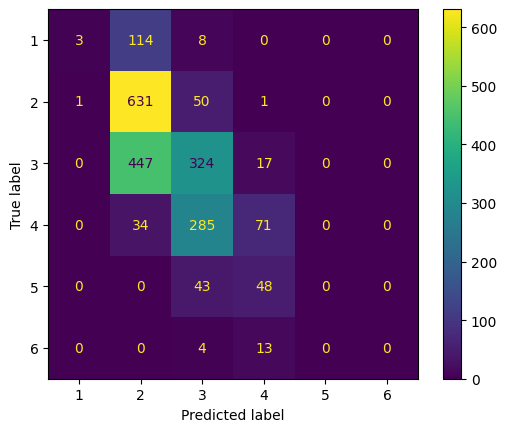

In [24]:
for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenizer, tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(tokenizer, config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=get_metric_function(),
    )

    trainer.train()

    y_true = valid["score"].values
    predictions0 = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(predictions0)

    plot_confusion_matrxi(y_true, y_pred)

    save_model_and_tokenizer(fold, tokenizer, trainer)

    save_oof_predictions(fold, valid, predictions0)